<a href="https://www.kaggle.com/code/mohamedmaher5/digit-recognizer?scriptVersionId=164453610" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd

data_path = '/kaggle/input/digit-recognizer/train.csv'

In [2]:
import pandas as pd
import numpy as np

def load_data(csv_file):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_file)
    
    # Extract the pixel data from the DataFrame
    pixel_data = df.values
#     print(pixel_data[0].shape[0]-1)
#     Reshape the pixel data to images
    images = []
    labels = []
    for pixels in pixel_data:
        # Reshape the pixel data to the original image shape (e.g., 224x224x3 for RGB images)
        image = pixels[1:].reshape((28, 28, 1))
        label = pixels[0]
        # Append the image to the list of images
        images.append(image)
        labels.append(label)
    
    return images, labels

In [3]:
images, labels = load_data(data_path)

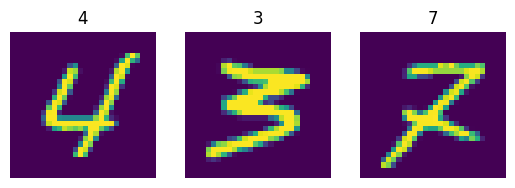

In [4]:
import matplotlib.pyplot as plt

# Define the indices of the images you want to display
indices = [882, 883, 884]

# Create a subplot for each image
for i, idx in enumerate(indices, start=1):
    plt.subplot(1, len(indices), i)
    plt.imshow(images[idx])
    plt.title(labels[idx])  # Add a title to the image
    plt.axis('off')  # Turn off axis

plt.show()

In [5]:
len(images),len(labels)

(42000, 42000)

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

def augment_images(images, rotation_range=20, width_shift_range=0.1,
                   height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                   horizontal_flip=True, fill_mode='nearest'):
    # Create an ImageDataGenerator object with the specified augmentations
    datagen = ImageDataGenerator(
        rotation_range=rotation_range,
        width_shift_range=width_shift_range,
        height_shift_range=height_shift_range,
        shear_range=shear_range,
        zoom_range=zoom_range,
        horizontal_flip=horizontal_flip,
        fill_mode=fill_mode
    )

    # Fit the ImageDataGenerator object to your data (optional)
    datagen.fit(images)

    # Generate augmented images
    augmented_images = []
    for img in images:
        augmented_img = next(datagen.flow(np.expand_dims(img, axis=0), batch_size=1))[0]
        augmented_images.append(augmented_img.squeeze())

    return augmented_images

2024-02-26 23:19:11.182577: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-26 23:19:11.182713: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-26 23:19:11.345677: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [7]:
# Generate augmented images for the first set
augmented_images1 = augment_images(images)

In [8]:
# Generate augmented images for the second set with different parameters
augmented_images2 = augment_images(images, rotation_range=30, width_shift_range=0.2,height_shift_range=0.2, shear_range=0.3, zoom_range=0.3)

In [9]:
# Combine lists into a list of tuples
all_images = images + augmented_images1 + augmented_images2
all_labels = labels*3

In [10]:
import cv2

all_images = [img.reshape(28, 28, 1) for img in all_images]
all_images = np.stack(all_images)
all_labels = np.array(all_labels)

In [11]:
all_images.shape

(126000, 28, 28, 1)

In [12]:
len(all_images),len(all_labels)

(126000, 126000)

In [13]:
import matplotlib.pyplot as plt
import numpy as np

def show_random_images(images, labels, num_images=12):
    # Get random indices
    random_indices = np.random.choice(len(images), size=num_images, replace=False)
    # Create subplots
    fig, axes = plt.subplots(3, 4, figsize=(7, 7))

    # Plot each image with its label
    for i, idx in enumerate(random_indices):
        row = i // 4
        col = i % 4
        ax = axes[row, col]
        ax.imshow(images[idx])
        ax.set_title(f"Label: {labels[idx]}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

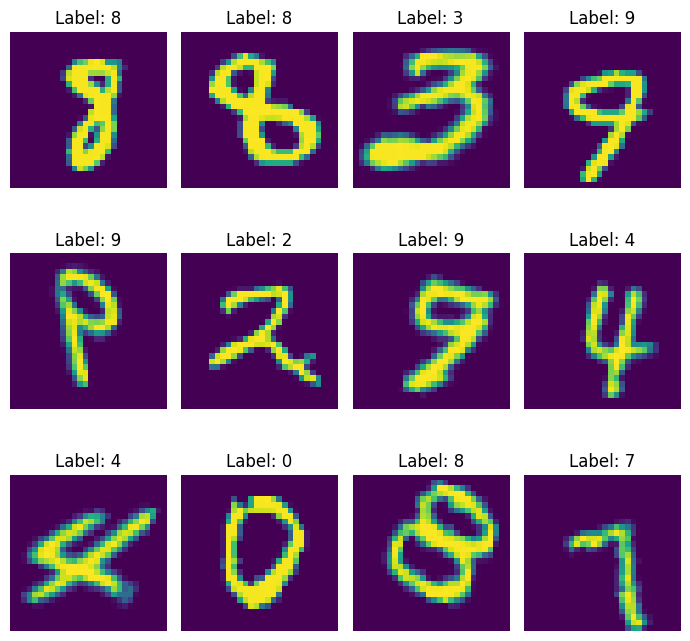

In [14]:
show_random_images(all_images, all_labels)

In [15]:
from sklearn.model_selection import train_test_split

train_images, temp_images , train_labels , temp_labels = train_test_split(all_images, all_labels, test_size=0.4, random_state=42)
val_images, test_images , val_labels , test_labels = train_test_split(temp_images, temp_labels, test_size=0.5, random_state=123)

In [16]:
## Model
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from keras.layers import Dense, BatchNormalization

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.20))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.55))
model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

## Summary about the Model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 32)        832       
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 20, 32)        25632     
                                                                 
 batch_normalization (Batch  (None, 20, 20, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 10, 10, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 10, 10, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          1

In [17]:
# Train the model (replace this with your training data and labels)
history = model.fit(train_images, train_labels, epochs=20, batch_size=64, validation_data=(val_images, val_labels))

Epoch 1/20


2024-02-26 23:20:05.271553: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1708989608.630129      72 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1182/1182 [==============================] - 15s 7ms/step - loss: 0.8075 - accuracy: 0.7409 - val_loss: 0.3165 - val_accuracy: 0.8998
Epoch 2/20
1182/1182 [==============================] - 7s 6ms/step - loss: 0.3752 - accuracy: 0.8825 - val_loss: 0.2192 - val_accuracy: 0.9311
Epoch 3/20
1182/1182 [==============================] - 7s 6ms/step - loss: 0.2832 - accuracy: 0.9136 - val_loss: 0.1883 - val_accuracy: 0.9429
Epoch 4/20
1182/1182 [==============================] - 7s 6ms/step - loss: 0.2412 - accuracy: 0.9273 - val_loss: 0.1619 - val_accuracy: 0.9501
Epoch 5/20
1182/1182 [==============================] - 7s 6ms/step - loss: 0.2081 - accuracy: 0.9362 - val_loss: 0.1605 - val_accuracy: 0.9509
Epoch 6/20
1182/1182 [==============================] - 7s 6ms/step - loss: 0.1899 - accuracy: 0.9423 - val_loss: 0.1411 - val_accuracy: 0.9569
Epoch 7/20
1182/1182 [==============================] - 7s 6ms/step - loss: 0.1754 - accuracy: 0.9470 - val_loss: 0.1403 - val_accuracy: 0.9587
Ep

In [18]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print("Test Accuracy:", test_accuracy)

788/788 [==============================] - 2s 3ms/step - loss: 0.1072 - accuracy: 0.9708
Test Accuracy: 0.9707936644554138


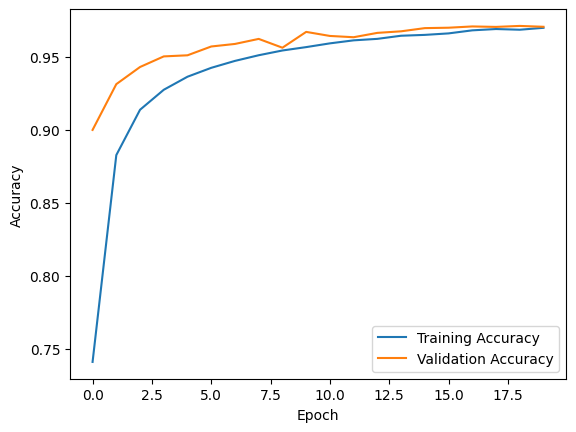

In [19]:
import matplotlib.pyplot as plt

# Plot Accuracy Curve
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

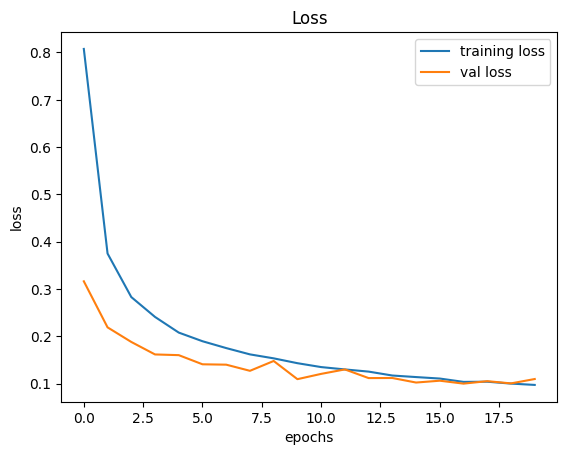

In [20]:
## Plot Loss Curve
plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [21]:
predictions = model.predict(test_images)
prediction_labels = []

for prediction in predictions:
  prediction_labels.append(np.argmax(prediction))

788/788 [==============================] - 2s 2ms/step


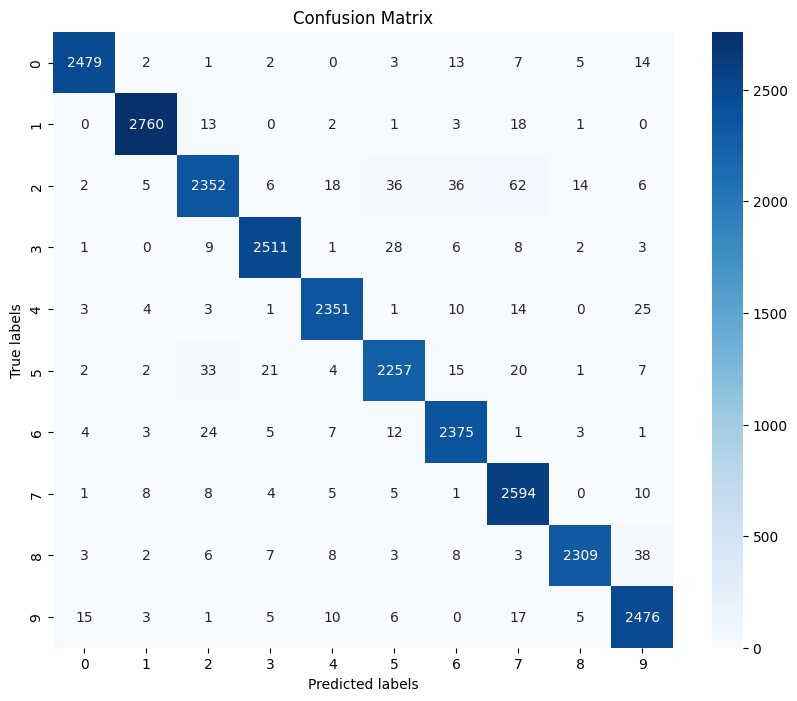

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate the confusion matrix
cm = confusion_matrix(test_labels, prediction_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()